# 1. Import Required Libraries

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge
import xgboost as xgb

import torch
import cv2
from torchvision import transforms
import torchvision.models as tv_models
from PIL import Image


# 2. Load Tabular Dataset

In [8]:
train_df = pd.read_excel("Downloads/train(1).xlsx")
test_df  = pd.read_excel("Downloads/test2.xlsx")

train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(train_df.shape, test_df.shape)


(16209, 21) (5404, 20)


# 3. Load Pre-Extracted Satellite Image Embeddings

In [3]:
X_train_images = np.load("data_cdc/X_train_image_embeddings.npy")
X_test_images  = np.load("data_cdc/X_test_image_embeddings.npy")

print(X_train_images.shape)
print(X_test_images.shape)


(16209, 512)
(5404, 512)


# 4. Tabular Feature Selection

In [4]:
TABULAR_FEATURES = [
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'view',
    'condition',
    'waterfront',
    'grade',
    'sqft_above',
    'sqft_basement',
    'lat',
    'long'
]


In [5]:
X_train_tabular = train_df[TABULAR_FEATURES].values
X_test_tabular  = test_df[TABULAR_FEATURES].values

y = train_df["price"].values


In [6]:
print("Tabular Train Shape:", X_train_tabular.shape)
print("Tabular Test Shape :", X_test_tabular.shape)
print("Image Train Shape :", X_train_images.shape)
print("Image Test Shape :", X_test_images.shape)


Tabular Train Shape: (16209, 13)
Tabular Test Shape : (5404, 13)
Image Train Shape : (16209, 512)
Image Test Shape : (5404, 512)


# 5. Multimodal Feature Fusion

In [7]:
X_train_fused = np.hstack([X_train_tabular, X_train_images])
X_test_fused  = np.hstack([X_test_tabular, X_test_images])

print("Fused Train Shape:", X_train_fused.shape)
print("Fused Test Shape :", X_test_fused.shape)


Fused Train Shape: (16209, 525)
Fused Test Shape : (5404, 525)


# 6. Train–Validation Split

In [8]:
X_tr_tab, X_val_tab, \
X_tr_img, X_val_img, \
X_tr_fused, X_val_fused, \
y_tr, y_val = train_test_split(
    X_train_tabular,
    X_train_images,
    X_train_fused,
    y,
    test_size=0.2,
    random_state=42
)

print(X_tr_tab.shape, X_val_tab.shape)
print(X_tr_img.shape, X_val_img.shape)
print(X_tr_fused.shape, X_val_fused.shape)
print(y_tr.shape, y_val.shape)


(12967, 13) (3242, 13)
(12967, 512) (3242, 512)
(12967, 525) (3242, 525)
(12967,) (3242,)


# 7. XGBoost Model – Tabular Only

In [9]:
xgb_tabular = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_tabular.fit(X_tr_tab, y_tr)

tab_preds = xgb_tabular.predict(X_val_tab)

rmse_tab = np.sqrt(mean_squared_error(y_val, tab_preds))
r2_tab   = r2_score(y_val, tab_preds)

print("Tabular XGBoost")
print("RMSE:", rmse_tab)
print("R² :", r2_tab)


Tabular XGBoost
RMSE: 119584.4110241799
R² : 0.8860419988632202


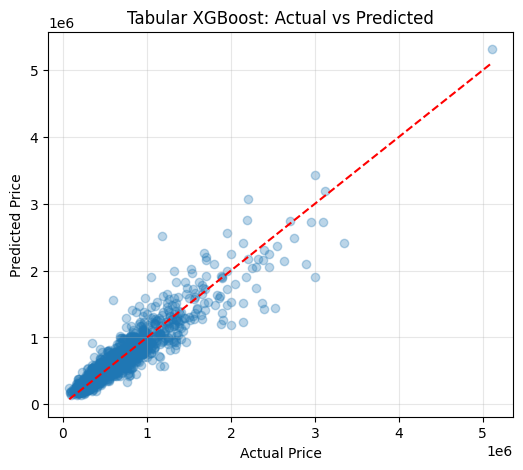

In [10]:
plt.figure(figsize=(6,5))
plt.scatter(y_val, tab_preds, alpha=0.3)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()], "r--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Tabular XGBoost: Actual vs Predicted")
plt.grid(alpha=0.3)
plt.show()


# 8. Image-Only Model (CNN Embeddings + XGBoost)

In [11]:
xgb_image = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_image.fit(X_tr_img, y_tr)

img_preds = xgb_image.predict(X_val_img)

rmse_img = np.sqrt(mean_squared_error(y_val, img_preds))
r2_img   = r2_score(y_val, img_preds)

print("Image-only XGBoost")
print("RMSE:", rmse_img)
print("R² :", r2_img)


Image-only XGBoost
RMSE: 303748.47700029705
R² : 0.2647688388824463


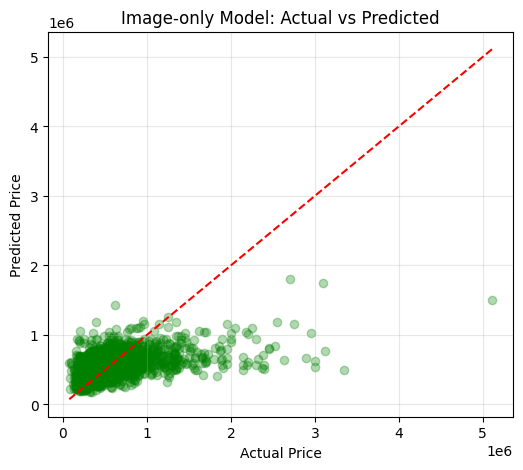

In [12]:
plt.figure(figsize=(6,5))
plt.scatter(y_val, img_preds, alpha=0.3, color="green")
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "r--")
plt.title("Image-only Model: Actual vs Predicted")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(alpha=0.3)
plt.show()

# 9. Multimodal XGBoost Model (Tabular + Image)

In [13]:
xgb_fused = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb_fused.fit(X_tr_fused, y_tr)

fused_preds = xgb_fused.predict(X_val_fused)

rmse_fused = np.sqrt(mean_squared_error(y_val, fused_preds))
r2_fused   = r2_score(y_val, fused_preds)

print("Fused Multimodal XGBoost")
print("RMSE:", rmse_fused)
print("R² :", r2_fused)


Fused Multimodal XGBoost
RMSE: 132312.5511809065
R² : 0.8604924082756042


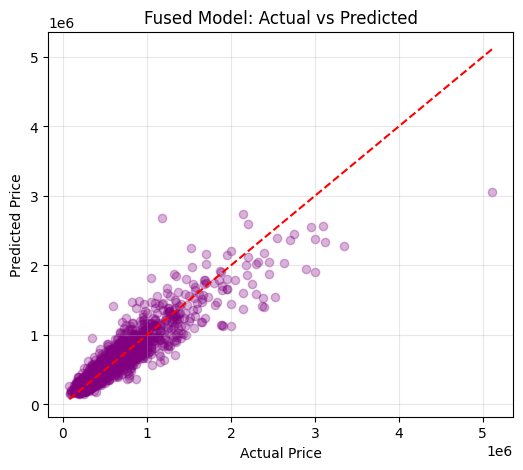

In [14]:
plt.figure(figsize=(6,5))
plt.scatter(y_val, fused_preds, alpha=0.3, color="purple")
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "r--")
plt.title("Fused Model: Actual vs Predicted")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(alpha=0.3)
plt.show()

# 10. Model Comparison

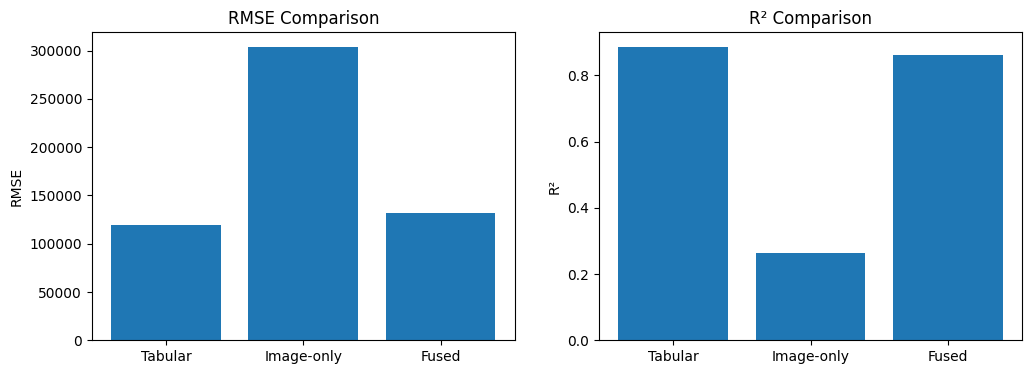

In [15]:
model_names = ["Tabular", "Image-only", "Fused"]
rmse_scores = [rmse_tab, rmse_img, rmse_fused]
r2_scores   = [r2_tab, r2_img, r2_fused]

fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].bar(model_names, rmse_scores)
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")

axes[1].bar(model_names, r2_scores)
axes[1].set_title("R² Comparison")
axes[1].set_ylabel("R²")

plt.show()


# 11. Residual Error Distribution

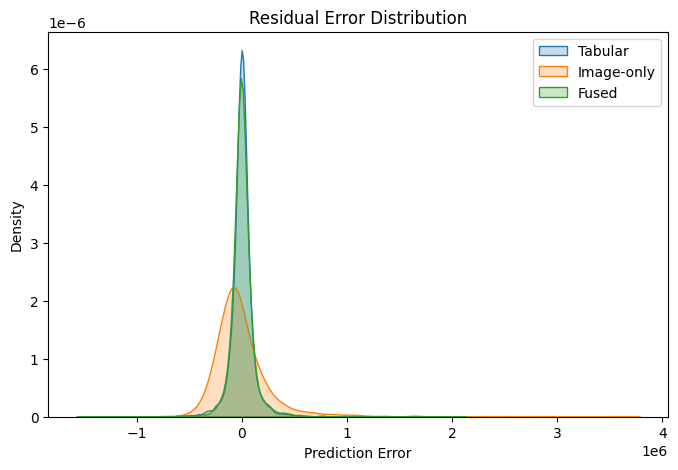

In [16]:
plt.figure(figsize=(8,5))
sns.kdeplot(y_val - tab_preds, label="Tabular", fill=True)
sns.kdeplot(y_val - img_preds, label="Image-only", fill=True)
sns.kdeplot(y_val - fused_preds, label="Fused", fill=True)
plt.xlabel("Prediction Error")
plt.title("Residual Error Distribution")
plt.legend()
plt.show()


# 12. Final Training on Full Dataset

In [17]:
final_xgb = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

final_xgb.fit(X_train_fused, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# 13. Test Prediction & Submission File

In [18]:
test_predictions = final_xgb.predict(X_test_fused)

submission = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": test_predictions
})

submission["predicted_price"] = submission["predicted_price"].round(2)
submission.to_csv("23323028_final(1).csv", index=False)

pd.options.display.float_format = '{:,.2f}'.format
submission.head()

submission.head()



,id,predicted_price
0,2591820310,"378,321.81"
1,7974200820,"922,766.19"
2,7701450110,"1,086,852.88"
3,9522300010,"2,141,135.50"
4,9510861140,"688,836.75"


# 14. Grad-CAM Visualization on Satellite Images
To interpret how satellite imagery contributes to property price prediction, Grad-CAM is applied on a pretrained ResNet18 model. This helps visualize the regions of satellite images that influence feature extraction.

In [1]:
import torch
from torchvision import transforms
import torchvision.models as tv_models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = tv_models.resnet18(
    weights=tv_models.ResNet18_Weights.DEFAULT
)
resnet.eval()
resnet = resnet.to(device)


In [2]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [3]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor):
        output = self.model(input_tensor)
        score = output[:, 0]
        self.model.zero_grad()
        score.backward()

        weights = torch.mean(self.gradients, dim=(2, 3))
        cam = torch.zeros(self.activations.shape[2:], dtype=torch.float32)

        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max() + 1e-8

        return cam.detach().cpu().numpy()


In [4]:
def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Cannot load image: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [9]:
import os

TRAIN_IMG_DIR = "data_cdc/satellite_images/train"
TEST_IMG_DIR  = "data_cdc/satellite_images/test"

# For train
train_df["image_path"] = train_df.index.map(
    lambda idx: os.path.join(TRAIN_IMG_DIR, f"{idx}.png")
)

# For test (optional, if needed later)
test_df["image_path"] = test_df.index.map(
    lambda idx: os.path.join(TEST_IMG_DIR, f"{idx}.png")
)

# Verify
print(train_df["image_path"].head())


0    data_cdc/satellite_images/train/0.png
1    data_cdc/satellite_images/train/1.png
2    data_cdc/satellite_images/train/2.png
3    data_cdc/satellite_images/train/3.png
4    data_cdc/satellite_images/train/4.png
Name: image_path, dtype: object


In [10]:
sample_paths = train_df["image_path"].iloc[:5].tolist()


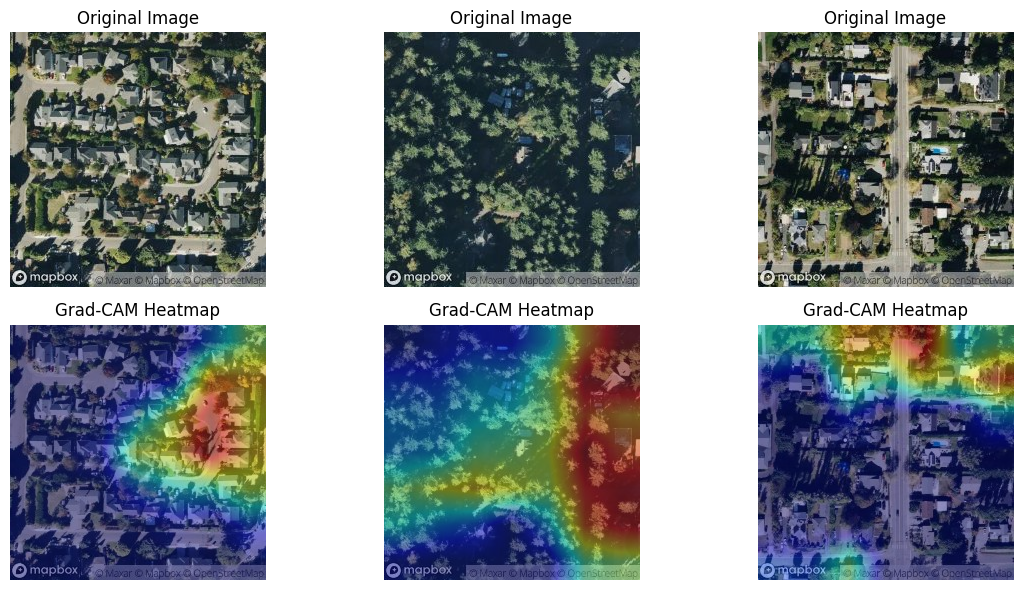

In [11]:
gradcam = GradCAM(resnet, resnet.layer4)

sample_paths = train_df["image_path"].sample(3, random_state=42).tolist()

plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    image = load_image(path)
    input_tensor = preprocess(image).unsqueeze(0)

    cam = gradcam.generate(input_tensor)
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 3, i + 4)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

plt.tight_layout()
plt.show()
